In [1]:
import numpy as np
import matplotlib
#matplotlib.use('nbagg') #efforts to zoom --2 (matplotlib plots)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
#efforts to zoom--1
# import mpld3 # this is very slowwww 
# mpld3.enable_notebook()

%matplotlib inline

In [2]:
%run ./importWalkingDataConfidence.ipynb

Dimension of walking test_x  =  (134, 27)
Dimension of walking train_x =  (536, 27)


In [3]:
def get_input_fn(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({k: data_x[k].values for k in FEATURESALL_WTS}),
      y = pd.DataFrame(data_y[LABEL].values),
      num_epochs=num_epochs,
      shuffle=shuffle)

In [4]:
LABEL_ID = 0;
LABEL = EMOSCORES[LABEL_ID]
WT_COL = WTS_LABEL[LABEL_ID]

In [5]:
embedded_ffp_column = tf.contrib.layers.embedding_column(
    tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64), dimension = 7)
# Continuous columns- frontKneesAngle	rearKneesAngle	frontAnkle	rearAnkle	frontHipsAngle
bodyZ = tf.feature_column.numeric_column("bodyAngleZ")
frontK = tf.feature_column.numeric_column("frontKneesAngle")
rearK = tf.feature_column.numeric_column("rearKneesAngle")
frontA = tf.feature_column.numeric_column("frontAnkle")
rearA = tf.feature_column.numeric_column("rearAnkle")
frontH = tf.feature_column.numeric_column("frontHipsAngle")
rearH = tf.feature_column.numeric_column("rearHipsAngle")
swingFtHt = tf.feature_column.numeric_column("swingFtHeight")
speed = tf.feature_column.numeric_column("speed")
gaitTime = tf.feature_column.numeric_column("gaitDuration")

feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, embedded_ffp_column]

In [6]:
# regressor = tf.estimator.DNNRegressor(
#   feature_columns=feature_cols, hidden_units=[100, 100],  model_dir="/DNN/quadMotionELU", optimizer = tf.train.AdamOptimizer(learning_rate=0.001), dropout = 0.1, activation_fn = tf.nn.elu)

# regressor = tf.contrib.learn.DNNRegressor(
#   feature_columns=feature_cols, hidden_units=[100, 100],  model_dir="/DNN/quadMotionConfidenceRELU", weight_column_name = WT_COL,
#     optimizer = tf.train.AdamOptimizer(learning_rate=0.001), dropout = 0.1)

regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_cols, hidden_units=[100, 100],  model_dir="/DNN/quadMotionConfidenceRELUDropout04EarlyStop", weight_column_name = WT_COL,
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001), dropout = 0.4,config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1))


INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_checkpoints_secs': 1, '_evaluation_master': '', '_task_type': None, '_tf_random_seed': None, '_session_config': None, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D5EB03F1D0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_ps_replicas': 0, '_environment': 'local', '_model_dir': '/DNN/quadMotionConfidenceRELUDropout04EarlyStop', '_task_id': 0, '_master': '', '_num_worker_replicas': 0, '_is_chief': True, '_save_summary_steps': 100, '_keep_checkpoint_max': 5}


In [7]:
 ev = regressor.evaluate(
     input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))
print('MSE (tensorflow): {0:f}'.format(ev['loss']))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Starting evaluation at 2017-09-27-15:49:29
INFO:tensorflow:Restoring parameters from /DNN/quadMotionConfidenceRELUDropout04EarlyStop\model.ckpt-850
INFO:tensorflow:Finished evaluation at 2017-09-27-15:49:30
INFO:tensorflow:Saving dict for global step 850: global_step = 850, loss = 14.1272
MSE (tensorflow): 14.127196


In [8]:
predictions = regressor.predict_scores(input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))
y_predicted = list(itertools.islice(predictions,y_test[LABEL].size))

INFO:tensorflow:Restoring parameters from /DNN/quadMotionConfidenceRELUDropout04EarlyStop\model.ckpt-850


In [9]:
# Score with sklearn.
score_sklearn = metrics.mean_squared_error(y_predicted, y_test[LABEL].values,sample_weight=X_test_all_wts[WT_COL])
print('MSE (sklearn): {0:f}'.format(score_sklearn))
r2_score = metrics.r2_score(y_test[LABEL], y_predicted, sample_weight=X_test_all_wts[WT_COL])
print('R2 (sklearn): {0:f}'.format(r2_score))

MSE (sklearn): 20.027115
R2 (sklearn): 0.434999


In [10]:
y_hat = pd.DataFrame(y_predicted, columns=["predicted_happy"], index=y_test[LABEL].index) 
y_test[LABEL]

98     35.832882
533    16.727348
235    28.033790
421    20.039478
2      28.210167
99     35.585371
40     18.441178
582    16.088111
286    28.529206
460    31.292538
419    21.575115
659    17.318055
91     20.816252
608    23.223020
596    20.067772
268    23.641136
217    22.868579
404    24.233680
26     29.964168
529    31.373120
479    18.623427
385    22.334702
97     27.824177
68     33.166887
412    32.853904
233    27.445447
651    18.788214
433    15.144414
188    23.825188
378    29.318471
         ...    
401    15.575888
232    19.380119
297    19.368628
89     18.566313
573    24.923224
478    22.948523
201    35.578657
228    22.474830
41     38.202983
278    14.167721
11     28.570411
504    19.092069
607    21.746343
643    28.152482
598    25.520545
593    24.377806
29     24.281018
588    17.198043
269    13.787126
237    17.840304
480    19.767796
5      21.575611
427    32.222035
208    30.092540
393    22.759171
303    22.325669
163    23.700262
319    22.5560

In [11]:
y_hat

predicted_happy
98         29.149084
533        21.141239
235        24.764904
421        22.397802
2          25.912260
99         32.472477
40         19.831657
582        21.255398
286        30.434338
460        31.517817
419        25.075724
659        18.633646
91         21.617645
608        23.800310
596        20.569735
268        22.964865
217        23.226748
404        26.613976
26         21.189554
529        29.268753
479        20.657816
385        21.158588
97         27.766592
68         28.789255
412        26.338251
233        19.905539
651        23.875187
433        22.938242
188        22.053619
378        31.649992
..               ...
401        22.239697
232        28.306664
297        21.955345
89         20.959982
573        21.517525
478        19.643496
201        28.013403
228        26.159143
41         28.376165
278        24.039722
11         20.577175
504        22.234392
607        21.141230
643        27.974794
598        24.992704
593        21.456995
29         21.141436
588        23.131536
269        20.706366
237        22.670778
480        22.898726
5          18.733585
427        30.781580
208        27.835434
393        27.273968
303        24.998407
163        26.140989
319        21.694990
597        19.721916
541        24.776215

[134 rows x 1 columns]

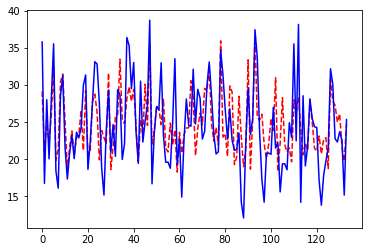

In [12]:
plt.figure()
plt.plot(y_hat.values,'r--',y_test[LABEL].values,'b')

In [13]:
y_all = pd.concat([y_hat, y_test[LABEL], y_test["happier_sigma"]], axis=1)
y_all

predicted_happy  happier_mu  happier_sigma
98         29.149084   35.832882       2.407094
533        21.141239   16.727348       5.789500
235        24.764904   28.033790       3.371890
421        22.397802   20.039478       5.026411
2          25.912260   28.210167       2.402066
99         32.472477   35.585371       2.012107
40         19.831657   18.441178       3.592258
582        21.255398   16.088111       5.706264
286        30.434338   28.529206       3.745952
460        31.517817   31.292538       2.153930
419        25.075724   21.575115       4.875246
659        18.633646   17.318055       6.044900
91         21.617645   20.816252       5.208921
608        23.800310   23.223020       5.638316
596        20.569735   20.067772       3.499354
268        22.964865   23.641136       5.133260
217        23.226748   22.868579       3.701063
404        26.613976   24.233680       5.377356
26         21.189554   29.964168       2.187889
529        29.268753   31.373120       2.131020
479        20.657816   18.623427       5.193378
385        21.158588   22.334702       5.131727
97         27.766592   27.824177       3.067399
68         28.789255   33.166887       2.237961
412        26.338251   32.853904       2.238605
233        19.905539   27.445447       3.305054
651        23.875187   18.788214       4.917566
433        22.938242   15.144414       5.493521
188        22.053619   23.825188       3.199613
378        31.649992   29.318471       3.512212
..               ...         ...            ...
401        22.239697   15.575888       5.455207
232        28.306664   19.380119       5.163268
297        21.955345   19.368628       5.344301
89         20.959982   18.566313       6.081598
573        21.517525   24.923224       6.019001
478        19.643496   22.948523       5.433050
201        28.013403   35.578657       2.217631
228        26.159143   22.474830       5.913607
41         28.376165   38.202983       2.745923
278        24.039722   14.167721       5.515768
11         20.577175   28.570411       3.486314
504        22.234392   19.092069       5.010983
607        21.141230   21.746343       4.851545
643        27.974794   28.152482       2.287253
598        24.992704   25.520545       3.282522
593        21.456995   24.377806       3.304624
29         21.141436   24.281018       6.239836
588        23.131536   17.198043       5.955683
269        20.706366   13.787126       5.274157
237        22.670778   17.840304       6.128548
480        22.898726   19.767796       5.046422
5          18.733585   21.575611       4.970507
427        30.781580   32.222035       2.167078
208        27.835434   30.092540       2.418731
393        27.273968   22.759171       5.455187
303        24.998407   22.325669       5.740031
163        26.140989   23.700262       6.228549
319        21.694990   22.556054       5.113738
597        19.721916   15.147500       5.914717
541        24.776215   25.349926       3.028491

[134 rows x 3 columns]

In [14]:
y_all_sorted = y_all.sort_values("happier_mu",ascending=[True])
y_all_sorted

predicted_happy  happier_mu  happier_sigma
55         18.979321   12.063560       5.021100
269        20.706366   13.787126       5.274157
278        24.039722   14.167721       5.515768
65         22.069067   14.194782       5.442390
104        23.009090   14.215905       5.380826
491        20.810514   14.875958       5.575036
433        22.938242   15.144414       5.493521
597        19.721916   15.147500       5.914717
401        22.239697   15.575888       5.455207
582        21.255398   16.088111       5.706264
220        22.027191   16.673583       6.019981
533        21.141239   16.727348       5.789500
588        23.131536   17.198043       5.955683
503        26.076204   17.307625       5.949658
659        18.633646   17.318055       6.044900
237        22.670778   17.840304       6.128548
40         19.831657   18.441178       3.592258
89         20.959982   18.566313       6.081598
479        20.657816   18.623427       5.193378
375        24.877439   18.770371       6.523414
651        23.875187   18.788214       4.917566
504        22.234392   19.092069       5.010983
561        18.256666   19.225744       6.590370
297        21.955345   19.368628       5.344301
232        28.306664   19.380119       5.163268
645        19.641710   19.428960       4.757468
399        21.508303   19.578080       5.124231
420        20.969759   19.607496       3.681642
480        22.898726   19.767796       5.046422
471        25.242363   19.962046       3.724462
..               ...         ...            ...
378        31.649992   29.318471       3.512212
507        26.064602   29.395832       7.171476
256        24.147226   29.439206       2.407164
441        27.828667   29.533864       3.436180
35         33.425667   29.671036       2.310562
19         29.175606   29.877500       2.286055
26         21.189554   29.964168       2.187889
208        27.835434   30.092540       2.418731
131        25.343588   30.544071       2.173157
460        31.517817   31.292538       2.153930
529        29.268753   31.373120       2.131020
440        22.976013   31.374994       2.186625
406        28.390306   32.156878       2.065765
427        30.781580   32.222035       2.167078
412        26.338251   32.853904       2.238605
388        24.664358   33.024580       2.309432
349        29.439869   33.066553       2.104151
133        32.517189   33.132164       2.581719
68         28.789255   33.166887       2.237961
87         23.971842   33.577144       2.308363
595        25.727318   33.731407       2.196092
258        35.983185   34.705092       2.442714
456        29.785236   35.325198       2.304957
201        28.013403   35.578657       2.217631
99         32.472477   35.585371       2.012107
98         29.149084   35.832882       2.407094
16         28.150957   36.438012       2.553544
451        36.421680   37.494617       2.324155
41         28.376165   38.202983       2.745923
489        35.478523   38.770583       2.563895

[134 rows x 3 columns]

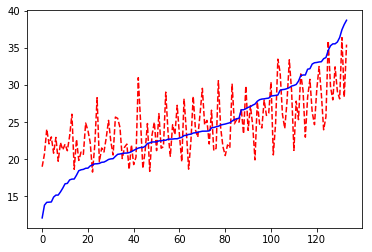

In [15]:
plt.figure()
plt.plot(y_all_sorted["predicted_happy"].values,'r--',y_all_sorted[LABEL].values,'b')

In [16]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)

Populating the interactive namespace from numpy and matplotlib


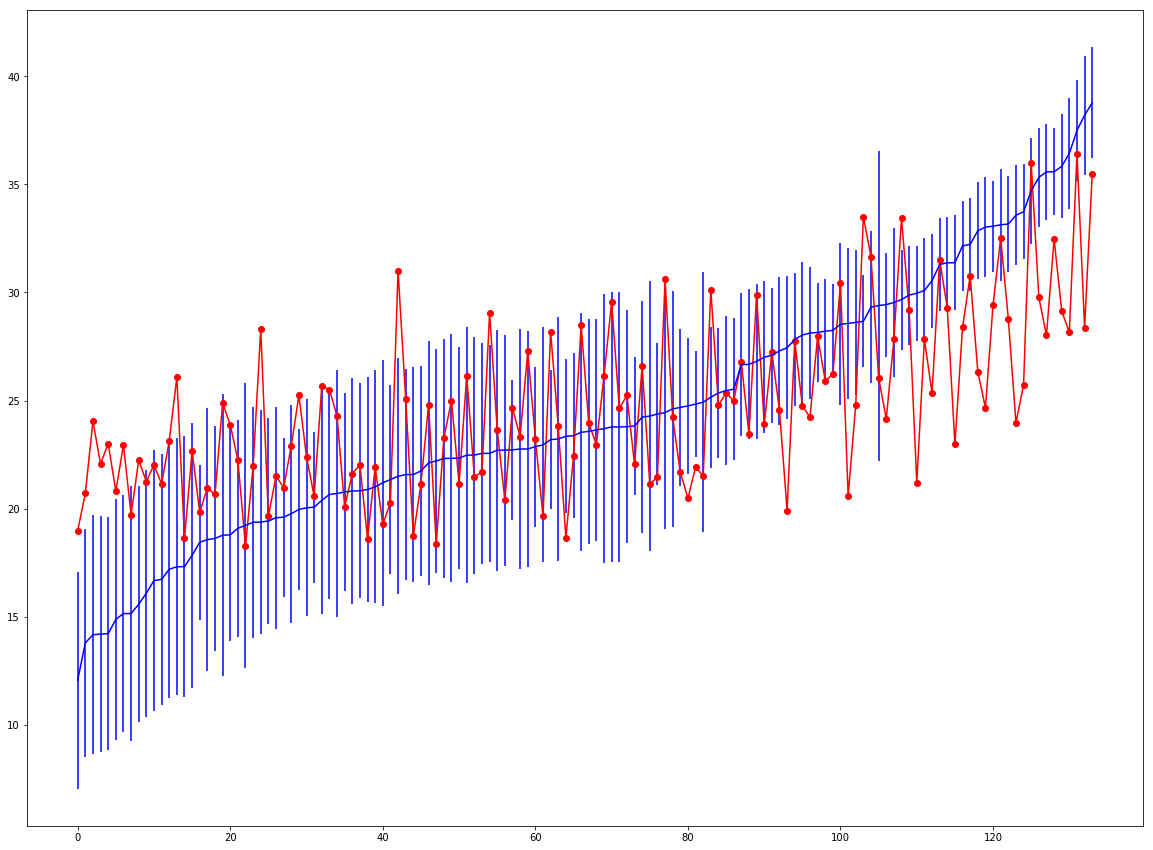

In [17]:
ax =plt.figure()
x = np.arange(0, y_all_sorted["predicted_happy"].size, 1)
plt.errorbar(x,y_all_sorted["predicted_happy"].values,yerr=0,fmt='r-o')
plt.errorbar(x,y_all_sorted[LABEL].values,yerr=y_all_sorted["happier_sigma"],fmt='b')
plt.show()

In [18]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [19]:
#sq_error = (y_predicted - np.array(y_test[LABEL].values).reshape(y_predicted.shape))**2

In [20]:
#np.sort(np.array(y_test[LABEL].values).reshape(y_predicted.shape),axis=0)